In [179]:
import networkx as nx
from scipy.linalg import expm, sinm, cosm
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import plotly.express as px
import osmnx as ox
from scipy import linalg
import matplotlib.patches as mpatches

In [180]:
def cosine_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =2 - 2*comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])
    return cd

def comm_angle(G, comm = None):
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)
    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    angle = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            angle[i][j] =np.degrees(np.arccos(comm[i][j]/np.sqrt(comm[i][i]*comm[j][j])))
    return angle




def comm_distance(G, comm = None): # returns a dataframe with a matrix
    G_simple = nx.Graph(G)
    if comm is None:
        comm = add_comm_attr(G_simple)

    comm = pd.DataFrame.from_dict(comm, orient= "columns")
    nodelist = list(G_simple)
    cd = pd.DataFrame.copy(comm)
    for i in nodelist:
        for j in nodelist:
            cd[i][j] =np.sqrt(comm[i][i] + comm[j][j] - 2*comm[i][j])
    return cd

def comm_geo(G, cd = None, comm = None): # adds mean flow as attribute and returns a matrix
  G_simple = nx.Graph(G)
  if cd is None:
    if comm is None:
      comm = add_comm_attr(G_simple)
    cd = comm_distance(G_simple, comm)
  dfA = nx.to_pandas_adjacency(G)
  X = (dfA*cd)
  GX = nx.from_pandas_adjacency(X, nx.DiGraph)
  dfSP = nx.to_pandas_adjacency(G)
  j = dict()
  for i in list(G.edges):
    try:
      j[i[0], i[1]] =  nx.dijkstra_path_length(GX, i[1], i[0], weight = "weight")
    except:
      j[i[0], i[1]] = 0

  # teste = pd.DataFrame.from_dict(j, orient = "index")
  # for i in teste.columns:
  #   for j in teste.columns:
  #     if np.isnan(teste[i][j]):
  #       dfSP[i][j] = 0
  #     else:
  #       dfSP[i][j] = teste[i][j]
  # nx.set_node_attributes(G, values=(dfSP.mean()).to_dict(), name="mean_flow")
  return j, cd


def add_CCC(G, comm = None, cd = None): # returns a dict with a centrality
    if cd is None:
        cd = cosine_distance(G,comm)
    d = (1/cd.sum())
    nx.set_node_attributes(G, values=d.to_dict(), name="CCC")
    return d




def add_comm_attr(G): # matrix and mean comm as attr
    # G_simple = nx.Graph(G)
    nodelist = list(G)
    A = nx.to_numpy_array(G, nodelist)

    Aexp2 = expm(A)
    mapping = dict(zip(nodelist, range(len(nodelist))))

    c = {}
    d = {}
    for u in G:
        c[u] = {}
        for v in G:
            c[u][v] = float(Aexp2[mapping[u], mapping[v]])
        d[u] = np.mean(list(c[u].values()))

    nx.set_node_attributes(G, values=d, name="comm")
    return c

def plotting(G, value, pos = None):
    groups = nx.get_node_attributes(G,value).values()
    mapping = dict(zip(count(),sorted(groups)))

    nodes = G.nodes()
    colors = [mapping[n] for n in nodes]

    # drawing nodes and edges separately so we can capture collection for colobar
    if not pos:
        pos = nx.spring_layout(G)
    plt.figure(figsize=(10,10))
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()


def graph_folium_bg(G, n_attribute = None, e_attribute = None, cmap = "hot", poly = None):
    nodes, edges = ox.graph_to_gdfs(G)
    if poly is not None:
        m = poly.explore()
        m = edges.explore(m=m, column = e_attribute, cmap = cmap, color = "black")
    else:
        m = edges.explore(column = e_attribute, cmap = cmap, color = "black")
    m = nodes.explore(m=m, column = n_attribute, cmap = cmap, color = "black")
    return m

def calculations(G):
    # nx.set_edge_attributes(G, flow, "Flow of returnal")
    # bet = nx.edge_betweenness_centrality(G, normalized = True)
    # nx.set_edge_attributes(G, bet, "Betweenness")

    j = dict()
    for i in list(G.edges):
        try:
            j[i[0], i[1]] =  nx.dijkstra_path_length(G, i[1], i[0])
        except:
            j[i[0], i[1]] = 0
    flow, X = comm_geo(G)
    df = pd.DataFrame(flow.values(), columns = ["Cost"], index = G.edges())
    nx.set_edge_attributes(G, flow, "COR")
    # df["Betweenness"] = bet.values()
    df["SP_inverse"] = j.values()
    return df

In [181]:
def simulation(G, k = [0], qtd = [1], tf = 100, dlambda = 0, dt = 0.01):
    N = len(G)
    A = nx.to_numpy_array(G, list(G), dtype = float).T
    lambda_1, eigenvector = linalg.eig(A, right = False, left = True)
    lambda_1 = np.max(lambda_1.real) - dlambda
    pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
    largest = (eigenvector.T[pos1].real)
    u0 = pd.DataFrame(data = np.zeros(N), index = G.nodes)
    cont = 0
    for i in k:
        u0.loc[i] = qtd[cont]
        cont+=1
    ut = [0,0]
    xi = lambda_1
    # time = np.arange(0,tf, 0.01)
    t = 0
    while(not np.all(np.isclose(ut[-1], ut[-2], atol = 1e-8, rtol = 1e-8)) or t < 2*dt):
    # while(t<100):
        ut.append(np.exp(-t*xi)*expm(t*A).dot(u0[0].to_numpy()))
        t+=dt
    ut.pop(0)
    ut.pop(0)
    return ut, largest, t

def simulation_conservative(G, k = [0], qtd = [1], dt = 0.01):
    N = len(G)
    L = nx.directed_laplacian_matrix(G).T
    u0 = pd.DataFrame(data = np.zeros(N), index = G.nodes)
    cont = 0
    for i in k:
        u0.loc[i] = qtd[cont]
        cont+=1
    ut = [0,0]
    # time = np.arange(0,tf, 0.01)
    t = 0
    while(not np.all(np.isclose(ut[-1], ut[-2], atol = 1e-8, rtol = 1e-8)) or t < 2*dt):
    # while(t<100):
        ut.append(expm(-t*L).dot(u0[0].to_numpy()))
        t+=dt
    ut.pop(0)
    ut.pop(0)
    return ut, t


def cycle_generator(n=3):
    if n < 3:
        print("Impossible to generate cycle")
        return None
    G = nx.DiGraph()
    for i in range(0, n-1):
        G.add_edge(i, i+1)
    G.add_edge(i+1, 0)
    return G

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

## Grid pequeno

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


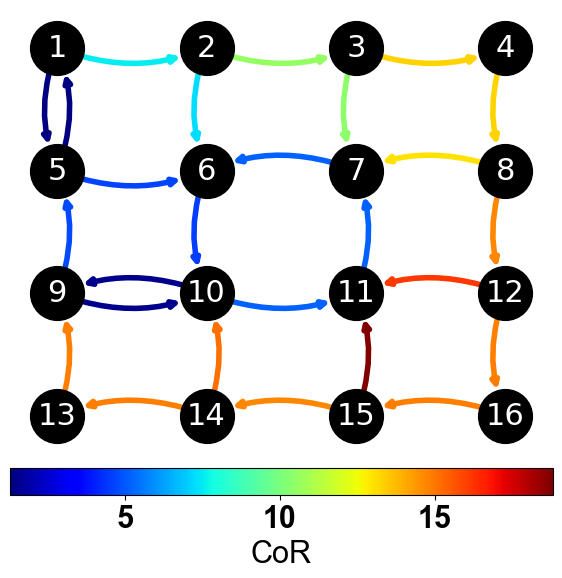

In [182]:
edgelist = [[1, 2], 
[3, 4],
[4, 8],
[2, 3],
[8, 12],
[12, 16],
[14, 13],
[9, 5], 
[5, 1],
[6, 10],
[16, 15],
[15, 14],
[10, 11],
[11, 7],
[7, 6],
[12, 11],
[10, 9],
[13, 9],
[1, 5],
[5, 6],
[9, 10],
[14, 10],
[15, 11],
[8, 7],
[3, 7],
[2, 6],
]


G = nx.from_edgelist(edgelist, create_using = nx.DiGraph)
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))
# pos = nx.kamada_kawai_layout(H)
pos = {x:((x-1)%4,-int((x-1)/4)) for x in H.nodes()}
# print(pos)
# nx.draw(H, pos = pos,connectionstyle='arc3, rad = 0.2', with_labels = True)
# plt.show()

all_u = []
all_t = []
df = calculations(H)
# colors=np.log(df["Cost"])
colors = df["Cost"]
vmin = min(colors)
vmax = max(colors)

cmap=plt.cm.jet
plt.figure(figsize=(7,7))
options = {
    "node_color": 'k',
    "edge_color": colors,
    "node_size": 1500,
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": vmin,
    "edge_vmax": vmax,
    "with_labels": True,
    'font_color': "w",
    'font_size': '22',
}


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation='horizontal', label = "CoR", pad = 0.025)
nx.draw(H, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
# plt.gca().set_facecolor("w")
plt.savefig("Results/small_grid.pdf")
plt.show()

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


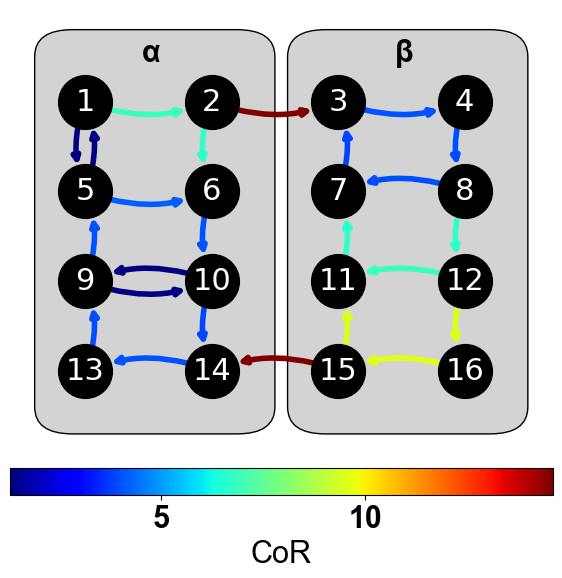

In [193]:
edgelist = [[1, 2], 
[3, 4],
[4, 8],
[2, 3],
[8, 12],
[12, 16],
[14, 13],
[9, 5], 
[5, 1],
[6, 10],
[16, 15],
[15, 14],
# [10, 11],
[11, 7],
# [7, 6],
[12, 11],
[10, 9],
[13, 9],
[1, 5],
[5, 6],
[9, 10],
# [14, 10],
[10, 14],
[15, 11],
[8, 7],
# [3, 7],
[7, 3],
[2, 6],
]


G = nx.from_edgelist(edgelist, create_using = nx.DiGraph)
H = nx.DiGraph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))
# pos = nx.kamada_kawai_layout(H)
pos = {x:((x-1)%4,-int((x-1)/4)) for x in H.nodes()}
# print(pos)
# nx.draw(H, pos = pos,connectionstyle='arc3, rad = 0.2', with_labels = True)
# plt.show()

all_u = []
all_t = []
df = calculations(H)
# colors=np.log(df["Cost"])

colors = df["Cost"]
vmin = min(colors)
vmax = max(colors)

cmap=plt.cm.jet
plt.figure(figsize=(7,7))
options = {
    "node_color": 'k',
    "edge_color": colors,
    "node_size": 1500,
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": vmin,
    "edge_vmax": vmax,
    "with_labels": True,
    'font_color': "w",
    'font_size': '22',
}


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation='horizontal', label = "CoR", pad = 0.025)
rectangle = matplotlib.patches.FancyBboxPatch((-0.1,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
plt.gca().add_patch(rectangle)

rectangle = matplotlib.patches.FancyBboxPatch((-0.1+2,-3.4), 1.3, 3.9, fc='lightgray',ec="black")
plt.gca().add_patch(rectangle)

plt.annotate(r"α", (0.45, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)
plt.annotate(r"β", (0.45+2, 0.45), xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None)

nx.draw(H, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)

# plt.gca().set_facecolor("w")
plt.savefig("Results/small_grid2.pdf")
plt.show()

In [112]:
print(list(nx.strongly_connected_components(G)))

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}]


In [80]:
mean_COR = []
mean_time = []
edges_used = []
edges_produced = []
for i in df.sort_values(by="Cost", ascending=False).index:
    if not H.has_edge(i[1], i[0]):
        G = nx.Graph.copy(H)
        G.add_edge(i[1],i[0])
        dfG = calculations(G)
        edges_used.append(i)
        edges_produced.append((i[1], i[0]))
        for i in H.nodes():
            ut, EC, t = simulation(G, [i], qtd = [1], dt = 0.002)
            all_u.append(ut[-1])
            all_t.append(t)
        # del(G)
        mean_COR.append(dfG["Cost"].mean())
        mean_time.append(np.mean(all_t))

C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is 

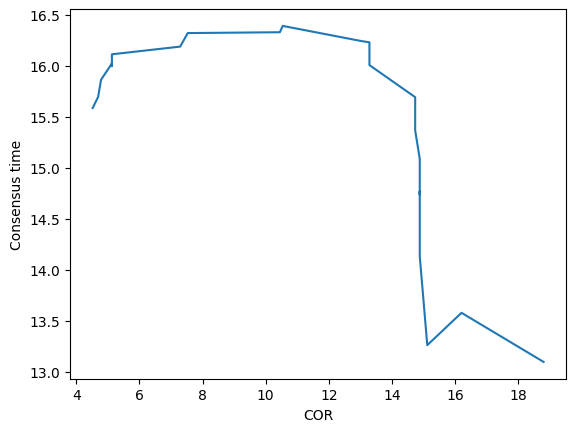

In [81]:
plt.plot(df.loc[edges_used], mean_time)
plt.xlabel("COR")
plt.ylabel("Consensus time")
plt.show()

Text(0, 0.5, 'Mean COR')

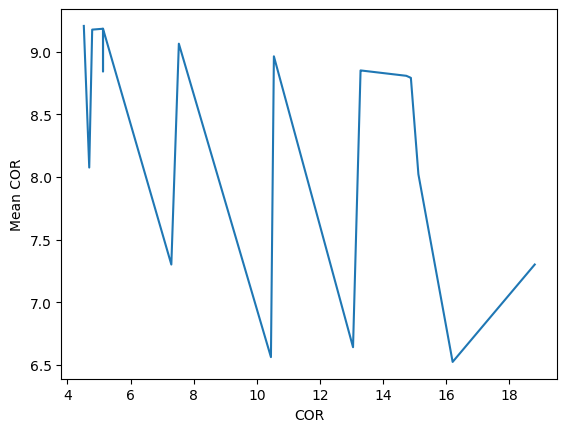

In [82]:
plt.plot(df.loc[edges_used], mean_COR)
plt.xlabel("COR")
plt.ylabel("Mean COR")

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


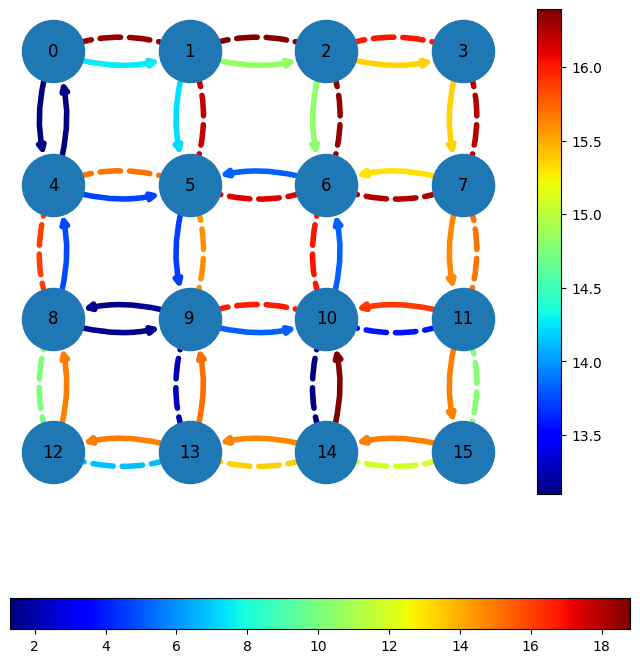

In [83]:

cmap=plt.cm.jet
plt.figure(figsize=(8,9))
options = {
    # "node_color": all_t,
    "node_size": 2000,
    "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": cmap,
    "cmap": cmap,
    "edge_vmin": min(df["Cost"]),
    "edge_vmax": max(df["Cost"]),
    "with_labels": True,
}

colors=df["Cost"]

vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation = "horizontal")

colors=mean_time

vmin = min(colors)
vmax = max(colors)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm2._A = []
plt.colorbar(sm2, ax = plt.gca(), orientation = "vertical")

nx.draw(H, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
nx.draw_networkx_edges(H, pos = pos, edgelist= edges_produced, connectionstyle='arc3, rad = 0.2', edge_color=mean_time, width = 4, style = 'dashed', edge_cmap = cmap)
plt.gca().set_facecolor("lightgray")

plt.show()

In [85]:
mean_COR = []
mean_time = []
edges_used = []

for i in df.sort_values(by="Cost", ascending=False).index:
    G = nx.Graph.copy(H)
    G.remove_edge(i[0],i[1])
    dfG = calculations(G)
    edges_used.append(i)
    for k in H.nodes():
        ut, EC, t = simulation(G, [k], qtd = [1], dt = 0.002)
        all_u.append(ut[-1])
        all_t.append(t)
    mean_COR.append(dfG["Cost"].mean())
    mean_time.append(np.mean(all_t))

C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is 

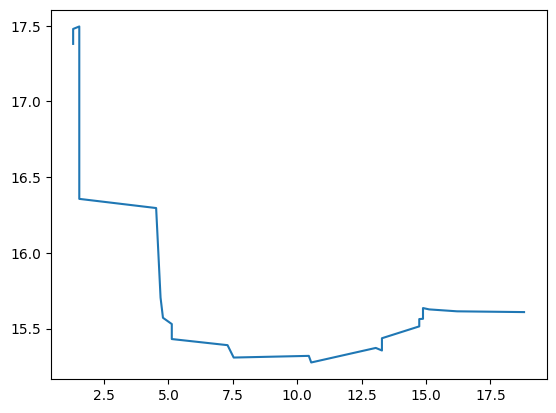

In [86]:
plt.plot(df.sort_values(by="Cost", ascending=False), mean_time)

C:\Users\gio-x\AppData\Local\Temp\ipykernel_11568\3477114923.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


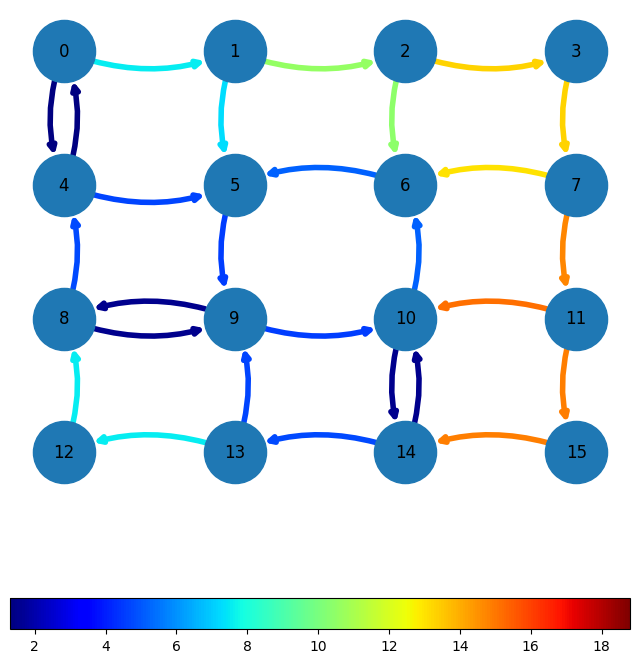

Adding an edge effects
Mean time of consensus: 1.4693181880077832
Mean cost of returning: 0.7604714195814931



In [88]:
G = nx.Graph.copy(H)
G.add_edge(10,14)
all_u = []
all_t = []
dfG = calculations(G)
for i in H.nodes():
    ut, EC, t = simulation(G, [i], qtd = [1])
    all_u.append(ut[-1])
    all_t.append(t)
dftimeG = pd.DataFrame(data = all_t, columns = ["time"], index = H.nodes())

cmap=plt.cm.jet
plt.figure(figsize=(8,9))
options = {
    # "node_color": all_t,
    "node_size": 2000,
    "edge_color": dfG["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": min(df["Cost"]),
    "edge_vmax": max(df["Cost"]),
    "with_labels": True,
}

colors=df["Cost"]

vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca(), orientation = "horizontal")
nx.draw(G, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
plt.gca().set_facecolor("lightgray")

plt.show()

print(f'''Adding an edge effects
Mean time of consensus: {dftimeG['time'].mean()/dftime['time'].mean()}
Mean cost of returning: {dfG['Cost'].mean()/df['Cost'].mean()}
''')

C:\Users\gio-x\AppData\Local\Temp\ipykernel_9552\3546754781.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]
C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


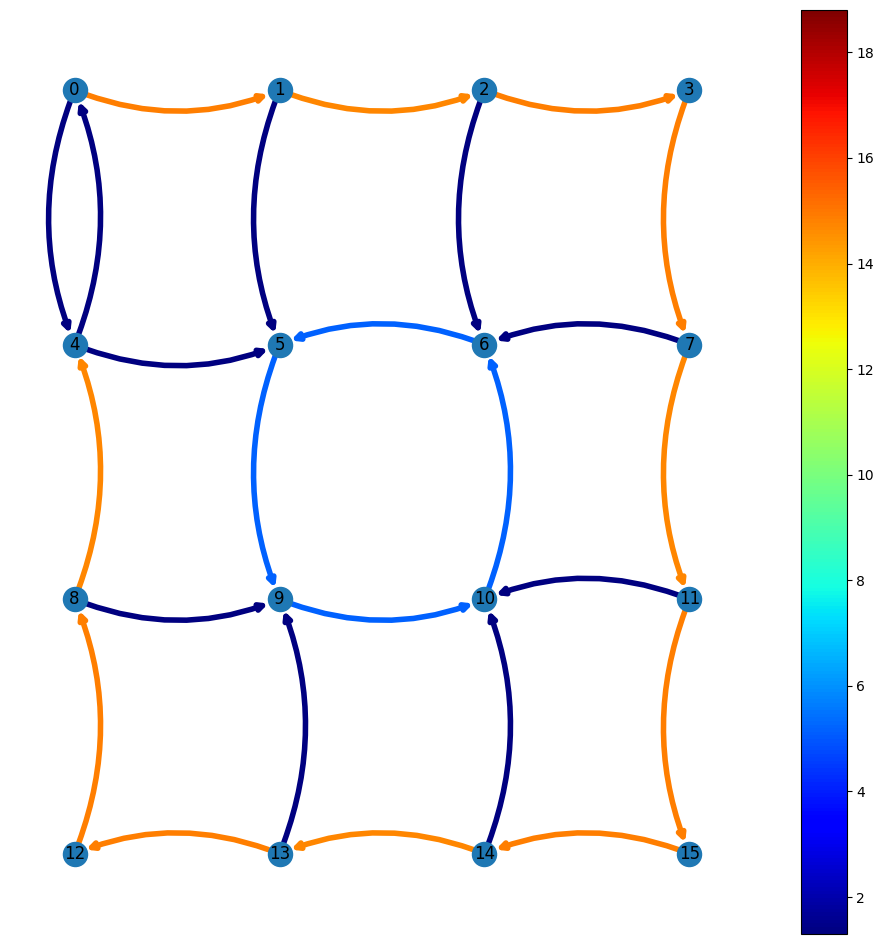

Removing an edge effects
Mean time of consensus: 4.370977917981275
Mean cost of returning: 0.7758618126825516

{9, 10, 5, 6}
{0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15}


In [141]:
G = nx.Graph.copy(H)
G.remove_edge(9,8)
all_u = []
all_t = []
dfG = calculations(G)
for i in H.nodes():
    ut, EC, t = simulation(G, [i], qtd = [1])
    all_u.append(ut[-1])
    all_t.append(t)
dftimeG = pd.DataFrame(data = all_t, columns = ["time"], index = H.nodes())

cmap=plt.cm.jet
plt.figure(figsize=(12,12))
options = {
    # "node_color": all_t,
    "edge_color": dfG["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": min(df["Cost"]),
    "edge_vmax": max(df["Cost"]),
    "with_labels": True,
}

colors=df["Cost"]

vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca())
nx.draw(G, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
plt.gca().set_facecolor("lightgray")

plt.show()

print(f'''Removing an edge effects
Mean time of consensus: {dftimeG['time'].mean()/dftime['time'].mean()}
Mean cost of returning: {dfG['Cost'].mean()/df['Cost'].mean()}
''')

for i in nx.strongly_connected_components(G):
    print(i)

## Cycles

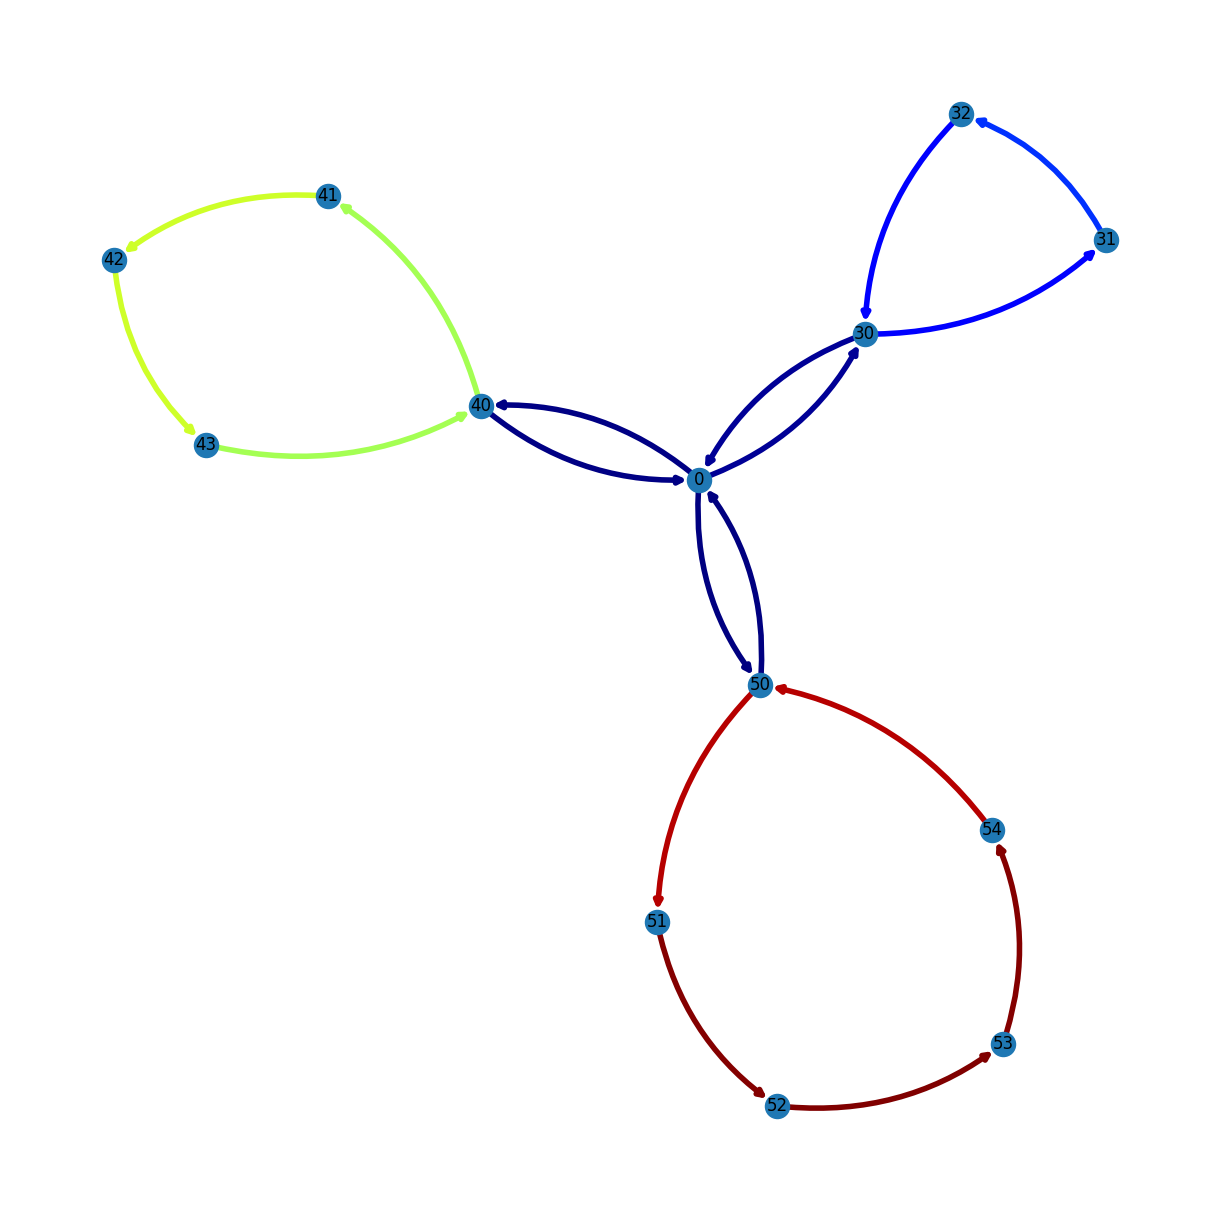

In [6]:
G = nx.DiGraph()
ini = 3
for n in range(ini,6):
    G = nx.union(G, cycle_generator(n), rename= ("", f"{n}"))
    G.add_edge(str(0),f"{n*10}")
    G.add_edge(f"{n*10}",str(0))

# nx.draw(G, with_labels = True)
df = calculations(G)
cmap=plt.cm.hot
plt.figure(figsize=(12,12))
options = {
    # "node_color": 'k',
    "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    # "cmap": cmap,
    "edge_vmin": df["Cost"].min(),
    "edge_vmax": df["Cost"].max(),
    "with_labels": True,
}

nx.draw(G, pos = nx.kamada_kawai_layout(G),connectionstyle='arc3, rad = 0.2' ,**options)
plt.gca().set_facecolor("lightgray")

plt.show()

In [111]:
df

Cost  Betweenness  SP_inverse
590  591   68.252771     0.499718          58
     0      1.209361     0.016667           1
591  592   68.378808     0.499718          58
592  593   68.392649     0.499718          58
593  594   68.393151     0.499718          58
...              ...          ...         ...
5955 5956  68.393151     0.499718          58
5956 5957  68.392649     0.499718          58
5957 5958  68.378808     0.499718          58
5958 590   68.252771     0.499718          58
0    590    1.209361     0.016667           1

[61 rows x 3 columns]

## Tadpole

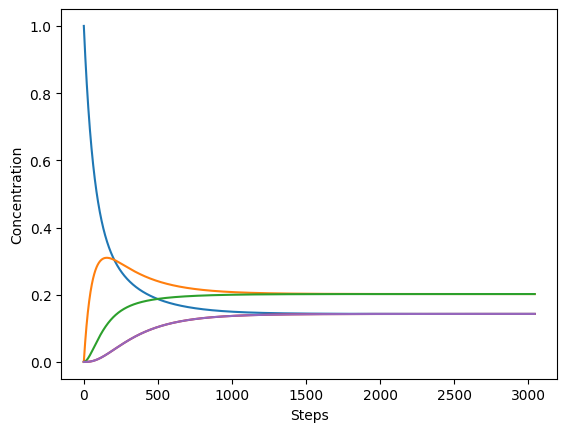

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


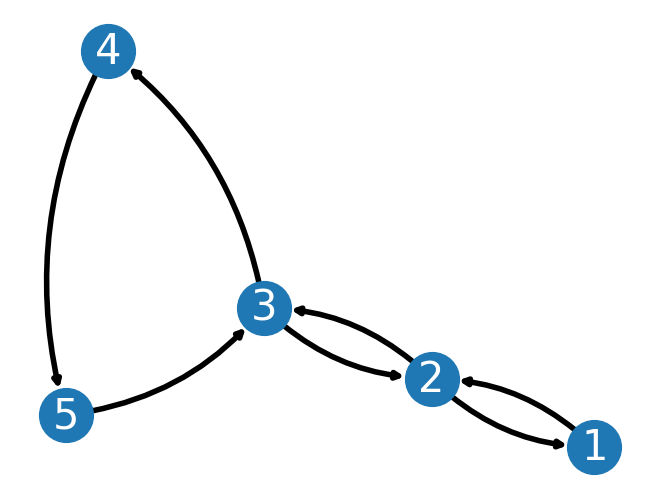

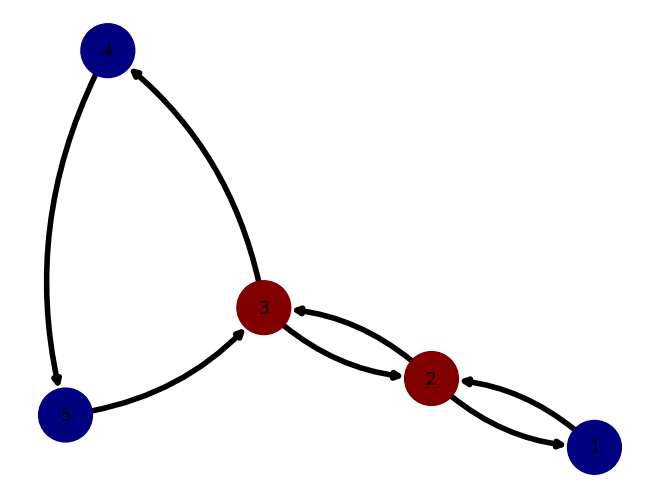

In [115]:
el = [[3, 2],
[3, 4],
[5, 3],
[1, 2],
[2, 3],
[2, 1],
[4, 5],
# [3, 1],
# [0, 5],
# [5, 6],
# [6, 7],
# [7, 0]
]



node_size = 1500
H = nx.from_edgelist(el, create_using=nx.DiGraph)
G = nx.DiGraph()
G.add_nodes_from(sorted(H.nodes(data=True)))
G.add_edges_from(H.edges(data=True))
pos = nx.kamada_kawai_layout(H)

ut, t = simulation_conservative(G, [1], qtd = [1])
x = np.arange(0,t-0.01, 0.01)

plt.plot(x/0.01,ut)
plt.xlabel("Steps")
plt.ylabel("Concentration")
plt.savefig("tadpole_conc.pdf", bbox_inches='tight')
plt.show()

plt.figure()
options = {
    # "node_color": ut[0],
    "node_size": node_size,
    # "edge_color": df["Cost"],
    "width": 4,
    # "edge_cmap": cmap2,
    "cmap": plt.cm.jet,
    "with_labels": True,
    'font_color': 'w',
    "font_size": 30
}
nx.draw(G, pos, connectionstyle='arc3, rad = 0.2', **options)
plt.savefig("tadpole_ini.png", bbox_inches='tight')
plt.show()

plt.figure()
options = {
    "node_color": ut[-1],
    # "edge_color": df["Cost"],
    "width": 4,
    # "edge_cmap": cmap2,
    "node_size": node_size,
    "cmap": plt.cm.jet,
    "with_labels": True,
    'font_color': "k"
}
nx.draw(G, pos, connectionstyle='arc3, rad = 0.2', **options)

# nx.draw(G, pos, node_color = ut[-1], with_labels = True)
plt.savefig("tadpole_end.png", bbox_inches='tight')
plt.show()


In [124]:
for i in ut:
    print(sum(i))

1.0
0.9985428318819733
0.9971001627241558
0.9956718479939708
0.9942577444272338
0.9928577100215212
0.9914716040294533
0.9900992869518997
0.9887406205311091
0.9873954677437679
0.9860636927939912
0.9847451611062505
0.9834397393182404
0.9821472952736892
0.9808676980151154
0.9796008177765361
0.9783465259761245
0.9771046952088288
0.9758751992389462
0.9746579129926609
0.9734527125505477
0.9722594751400419
0.971078079127881
0.9699084040125192
0.9687503304165176
0.9676037400789129
0.9664685158475665
0.9653445416714963
0.9642317025931946
0.9631298847409326
0.9620389753210555
0.9609588626102679
0.9598894359479139
0.9588305857282533
0.9577822033927337
0.9567441814222633
0.955716413329485
0.9546987936510523
0.9536912179399112
0.9526935827575864
0.951705785666477
0.9507277252221612
0.9497593009657108
0.9488004134160184
0.9478509640621388
0.9469108553556441
0.9459799907029961
0.9450582744579349
0.9441456119138871
0.9432419092963942
0.9423470737555595
0.9414610133585201
0.9405836370819397
0.939714854

In [119]:
all_u = []
all_t = []
df = calculations(G)
for i in range(1, len(G)+1):
    ut, t = simulation_conservative(G, [i], qtd = [1])
    all_u.append(ut[-1])
    all_t.append(t)

dftime = pd.DataFrame(data = all_t, columns = ["time"], index = G.nodes())

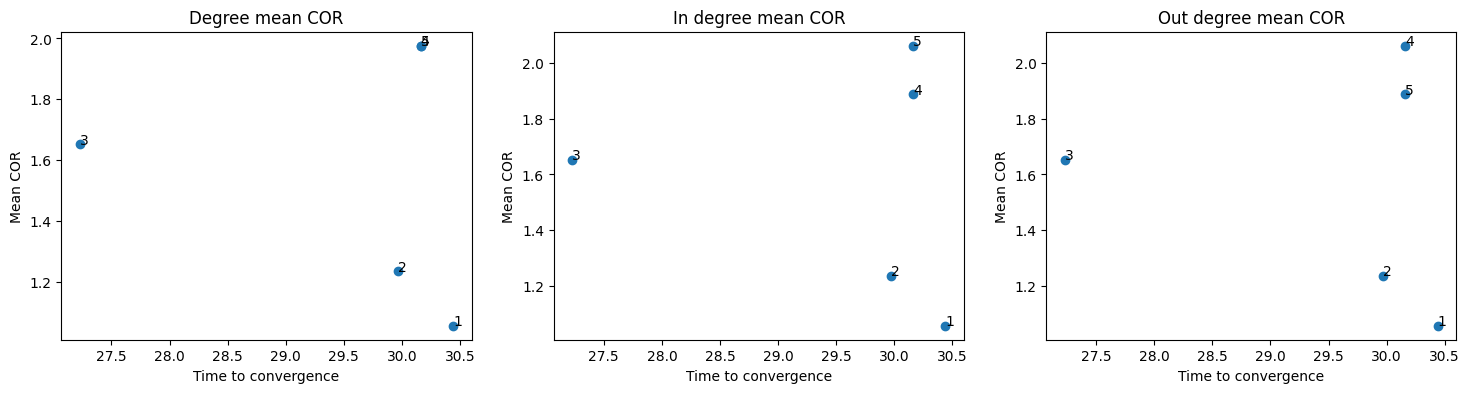

In [120]:
plt.figure(figsize = (18,4))
plt.subplot(1, 3, 1)
plt.title("Degree mean COR")
dftime["COR str"] = dict(G.degree(weight = 'COR'))
dftime["degree"] = dict(G.degree())
plt.ylabel("Mean COR")
plt.xlabel("Time to convergence")
for i, txt in enumerate(dftime.index):
    plt.annotate(txt, (dftime['time'].loc[txt], (dftime["COR str"]/dftime["degree"])[txt]))
plt.plot(dftime["time"],dftime["COR str"]/dftime["degree"], 'o')

plt.subplot(1, 3, 2)
plt.title("In degree mean COR")
dftime["COR in_str"] = dict(G.in_degree(weight = 'COR'))
dftime["in_degree"] = dict(G.in_degree())
plt.ylabel("Mean COR")
plt.xlabel("Time to convergence")
for i, txt in enumerate(dftime.index):
    plt.annotate(txt, (dftime['time'].loc[txt], (dftime["COR in_str"]/dftime["in_degree"])[txt]))
plt.plot(dftime["time"],dftime["COR in_str"]/dftime["in_degree"], 'o')

plt.subplot(1, 3, 3)
plt.title("Out degree mean COR")
dftime["COR out_str"] = dict(G.out_degree(weight = 'COR'))
dftime["out_degree"] = dict(G.out_degree())
plt.ylabel("Mean COR")
plt.xlabel("Time to convergence")
for i, txt in enumerate(dftime.index):
    plt.annotate(txt, (dftime['time'].loc[txt], (dftime["COR out_str"]/dftime["out_degree"])[txt]))
plt.plot(dftime["time"],dftime["COR out_str"]/dftime["out_degree"], 'o')
plt.show()

In [78]:
plt.rcParams.update({'font.size': 22})

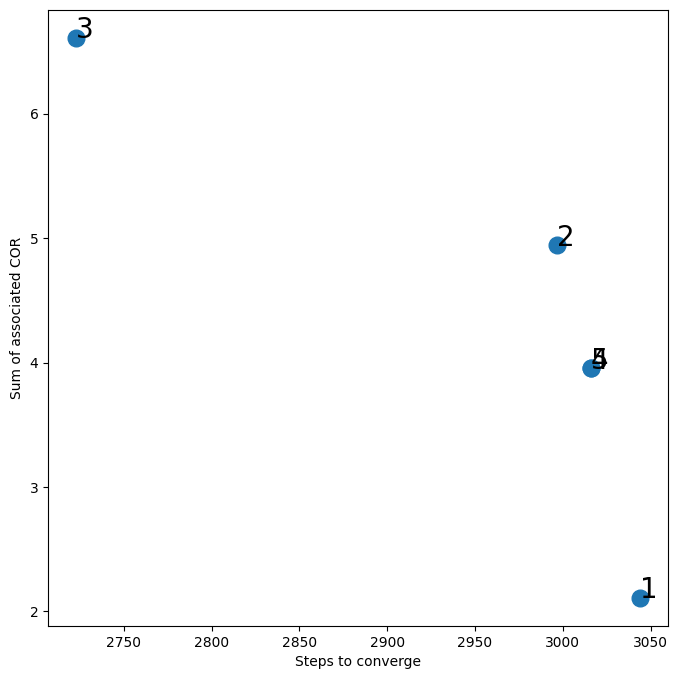

In [121]:
plt.figure(figsize = (8,8))
# plt.subplot(1, 3, 1)
# plt.title("Degree strength")
dftime["COR str"] = dict(G.degree(weight = 'COR'))
dftime["degree"] = dict(G.degree())
for i, txt in enumerate(dftime.index):
    plt.annotate(txt, (dftime['time'].loc[txt]/0.01, dftime["COR str"].loc[txt]), size = 20)
plt.plot(dftime["time"]/0.01,dftime["COR str"], 'o', markersize = 12)
plt.ylabel("Sum of associated COR")
plt.xlabel("Steps to converge")
plt.savefig(f"dynamics_conv_cor.pdf", bbox_inches='tight')
plt.show()

# # plt.subplot(1, 3, 2)
# plt.title("In degree strength")
# dftime["COR in_str"] = dict(G.in_degree(weight = 'COR'))
# dftime["in_degree"] = dict(G.in_degree())
# for i, txt in enumerate(dftime.index):
#     plt.annotate(txt, (dftime['time'].loc[txt], dftime["COR in_str"].loc[txt]))
# plt.plot(dftime["time"],dftime["COR in_str"], 'o')
# plt.show()

# plt.subplot(1, 3, 3)
# plt.title("Out degree strength")
# dftime["COR out_str"] = dict(G.out_degree(weight = 'COR'))
# dftime["out_degree"] = dict(G.out_degree())
# plt.ylabel("Strength to COR")
# plt.xlabel("Time to convergence")
# for i, txt in enumerate(dftime.index):
#     plt.annotate(txt, (dftime['time'].loc[txt], dftime["COR out_str"].loc[txt]))
# plt.plot(dftime["time"],dftime["COR out_str"], 'o')
# plt.show()

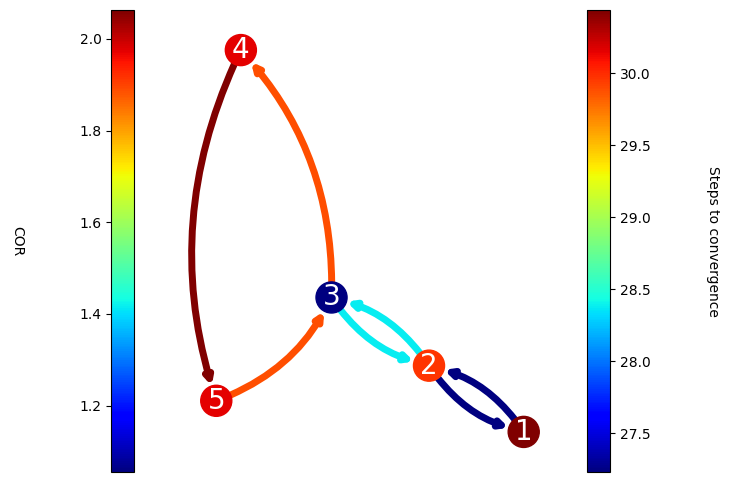

In [122]:
cmap=plt.cm.jet
cmap2=plt.cm.jet

options = {
    "node_color": all_t,
    "edge_color": df["Cost"],
    # "width": dict(zip(G.edges(),df["Cost"])),
    "edge_cmap": cmap2,
    "cmap": cmap,
    "with_labels": True,
    'font_size': 20,
    'font_color': 'w',
    'width' : 5 ,
    'node_size': 500
}


plt.figure(figsize=(8,6))

colors=all_t
cmap=plt.cm.jet
vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('Steps to convergence', rotation=270, labelpad = 50)

colors2=df["Cost"]
vmin2 = min(colors2)
vmax2 = max(colors2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin = vmin2, vmax=vmax2))
sm._A = []
cbar = plt.colorbar(sm, ax = plt.gca(), orientation = 'vertical', location = "left")
cbar.set_label('COR', rotation=270, labelpad = 50)

nx.draw(G, pos, vmin=vmin, vmax=vmax, connectionstyle='arc3, rad = 0.2',**options)
# nx.draw(G, pos, connectionstyle='arc3, rad = 0.2', width = list(df["Cost"]*2) ,**options)
plt.savefig("tadpoleCOR.pdf", bbox_inches='tight')
plt.show()

## Directed grid

In [58]:
_G = nx.DiGraph(nx.grid_2d_graph(5,5))
pos = {f'G({x}, {y})':(y,-x) for x,y in _G.nodes()}
pos.update({f'H({x}, {y})':(y, 20-x) for x,y in _G.nodes()})
G = nx.union(_G, _G, rename = ("G", "H"))
G.add_edge("H(4, 4)", "G(0, 4)")
# G.add_edge("H(4, 3)", "G(0, 3)")

G.add_edge("G(0, 0)", "H(4, 0)")
# G.add_edge("G(0, 1)", "H(4, 1)")

In [59]:
ut, EC, t = simulation(G, [list(G.nodes())[0]], [1], tf = 100)

C:\Users\gio-x\AppData\Local\Temp\ipykernel_25372\1086092214.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]


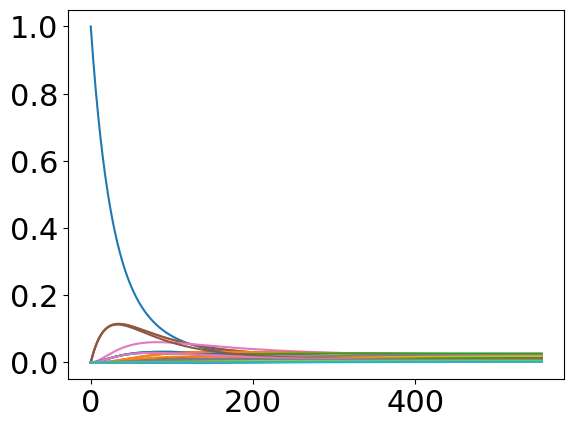

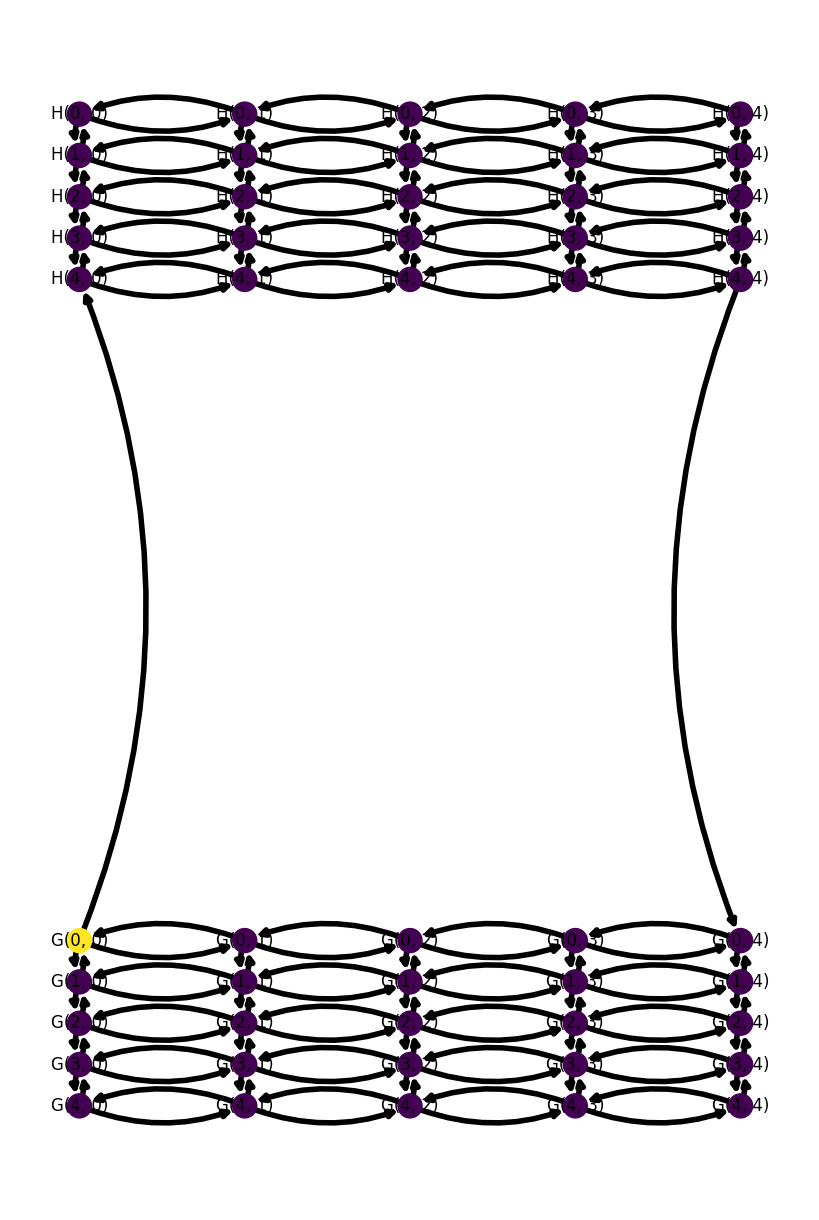

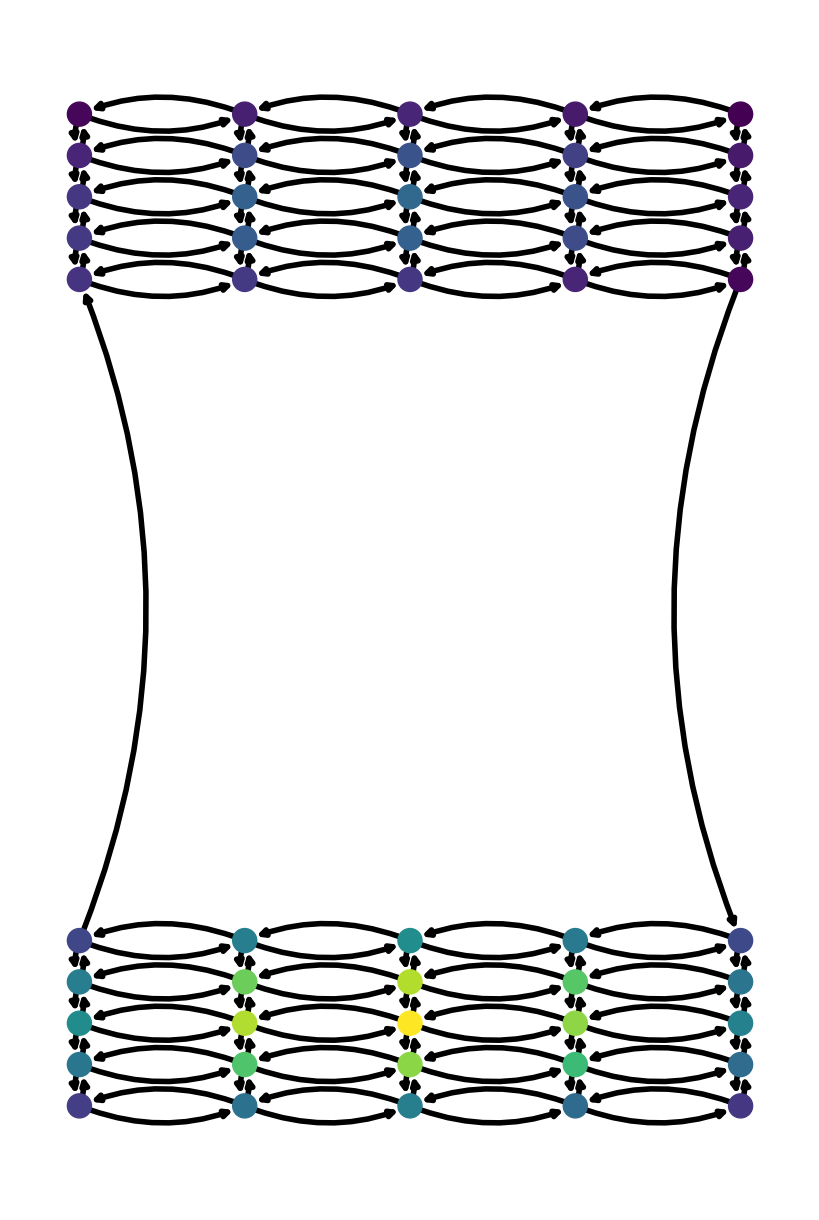

In [60]:
plt.plot(ut)
plt.show()


plt.figure(figsize=(8,12))
options = {
    "node_color": ut[0],
    # "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "with_labels": True,
}
nx.draw(G, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
plt.show()

plt.figure(figsize=(8,12))
options = {
    "node_color": ut[-1],
    # "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "with_labels": False,

}
nx.draw(G, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
plt.show()
# nx.draw(G, pos, node_color = ut[-1], with_labels = True)

In [61]:
all_u = []
all_t = []
df = calculations(G)
for i in G.nodes():
    ut, EC, t = simulation(G, [i], qtd = [1])
    all_u.append(ut[-1])
    all_t.append(t)
dftime = pd.DataFrame(data = all_t, columns = ["time"], index = G.nodes())

C:\Users\gio-x\AppData\Local\Temp\ipykernel_25372\1086092214.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]


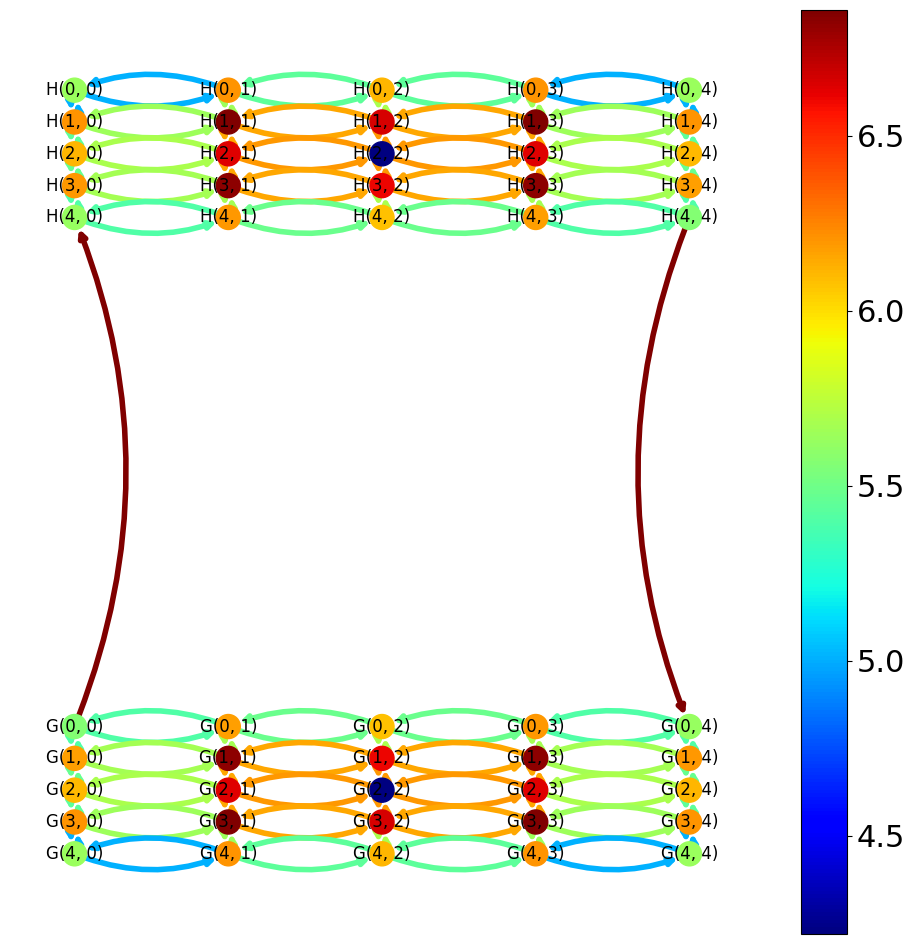

In [62]:
cmap=plt.cm.jet
plt.figure(figsize=(12,12))
options = {
    "node_color": all_t,
    "edge_color": df["Cost"],
    "width": 4,
    "edge_cmap": plt.cm.jet,
    "cmap": cmap,
    "edge_vmin": 1,
    "edge_vmax": 2,
    "with_labels": True,
}

colors=all_t

vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax = plt.gca())
nx.draw(G, pos = pos,connectionstyle='arc3, rad = 0.2' ,**options)
plt.gca().set_facecolor("lightgray")

plt.show()

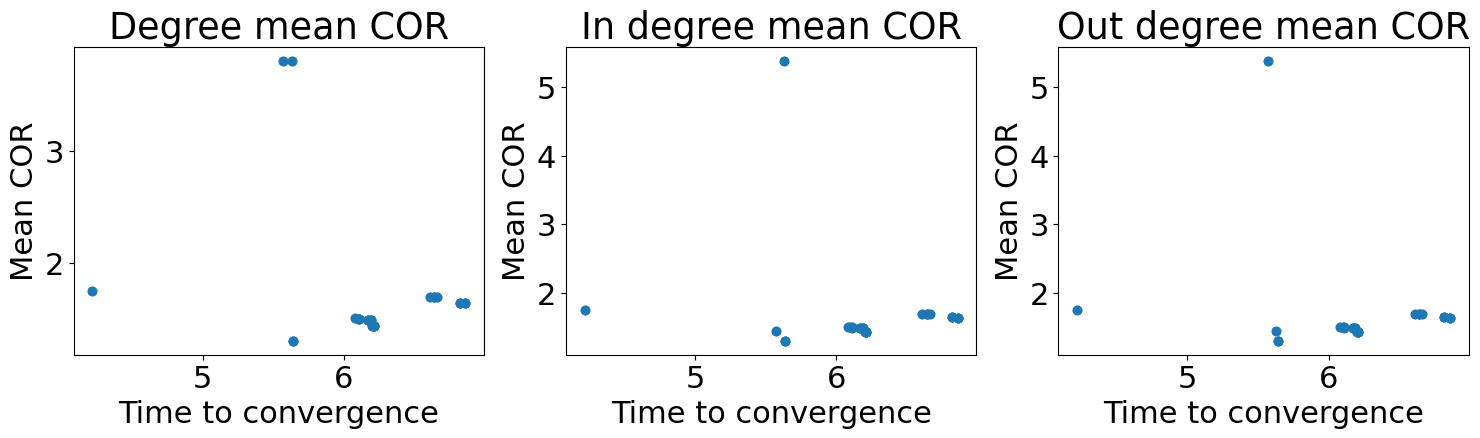

In [63]:
plt.figure(figsize = (18,4))
plt.subplot(1, 3, 1)
plt.title("Degree mean COR")
dftime["COR str"] = dict(G.degree(weight = 'COR'))
dftime["degree"] = dict(G.degree())
plt.ylabel("Mean COR")
plt.xlabel("Time to convergence")
plt.plot(dftime["time"],dftime["COR str"]/dftime["degree"], 'o')

plt.subplot(1, 3, 2)
plt.title("In degree mean COR")
dftime["COR in_str"] = dict(G.in_degree(weight = 'COR'))
dftime["in_degree"] = dict(G.in_degree())
plt.ylabel("Mean COR")
plt.xlabel("Time to convergence")
plt.plot(dftime["time"],dftime["COR in_str"]/dftime["in_degree"], 'o')

plt.subplot(1, 3, 3)
plt.title("Out degree mean COR")
dftime["COR out_str"] = dict(G.out_degree(weight = 'COR'))
dftime["out_degree"] = dict(G.out_degree())
plt.ylabel("Mean COR")
plt.xlabel("Time to convergence")
plt.plot(dftime["time"],dftime["COR out_str"]/dftime["out_degree"], 'o')
plt.show()

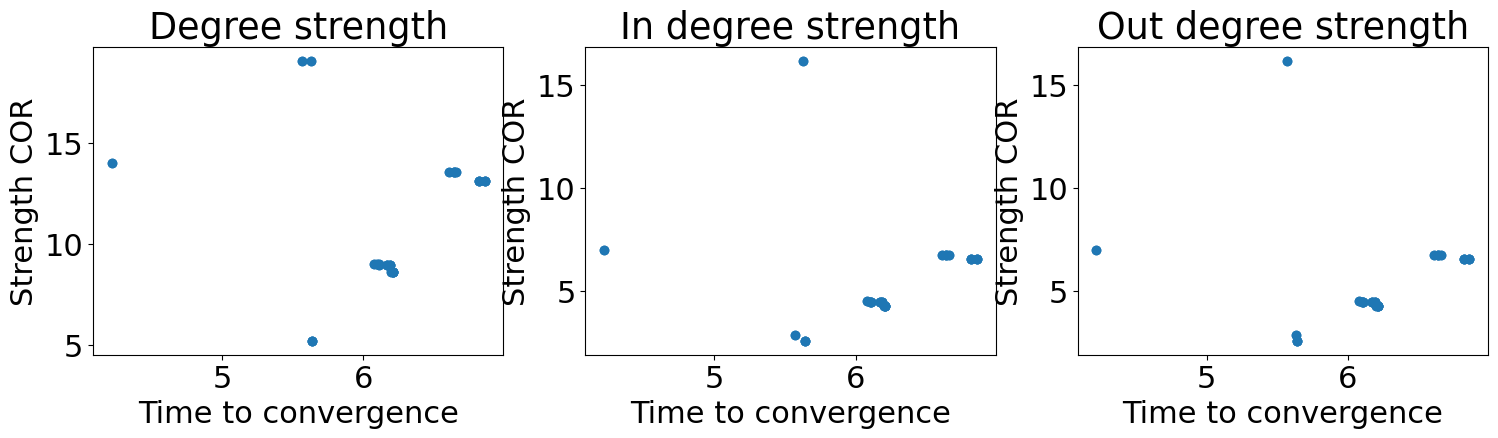

In [64]:
plt.figure(figsize = (18,4))
plt.subplot(1, 3, 1)
plt.title("Degree strength")
dftime["COR str"] = dict(G.degree(weight = 'COR'))
dftime["degree"] = dict(G.degree())
plt.ylabel("Strength COR")
plt.xlabel("Time to convergence")
plt.plot(dftime["time"],dftime["COR str"], 'o')

plt.subplot(1, 3, 2)
plt.title("In degree strength")
dftime["COR in_str"] = dict(G.in_degree(weight = 'COR'))
dftime["in_degree"] = dict(G.in_degree())
plt.ylabel("Strength COR")
plt.xlabel("Time to convergence")
plt.plot(dftime["time"],dftime["COR in_str"], 'o')

plt.subplot(1, 3, 3)
plt.title("Out degree strength")
dftime["COR out_str"] = dict(G.out_degree(weight = 'COR'))
dftime["out_degree"] = dict(G.out_degree())
plt.ylabel("Strength COR")
plt.xlabel("Time to convergence")
plt.plot(dftime["time"],dftime["COR out_str"], 'o')
plt.show()

## Karate

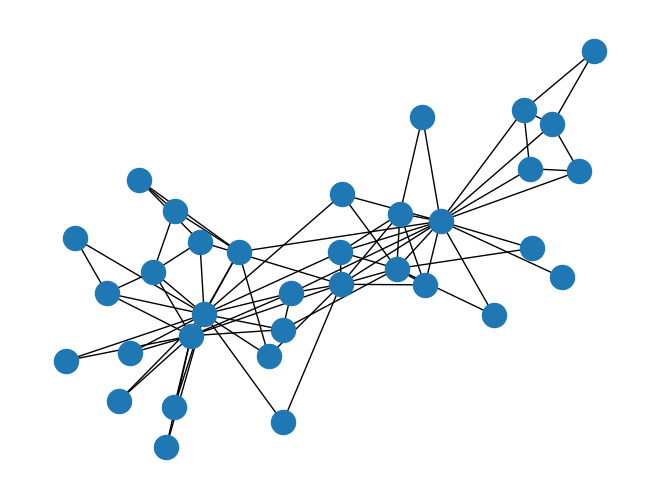

In [65]:
K = nx.karate_club_graph()
nx.draw(K) 

In [66]:
K.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

## Cidade

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


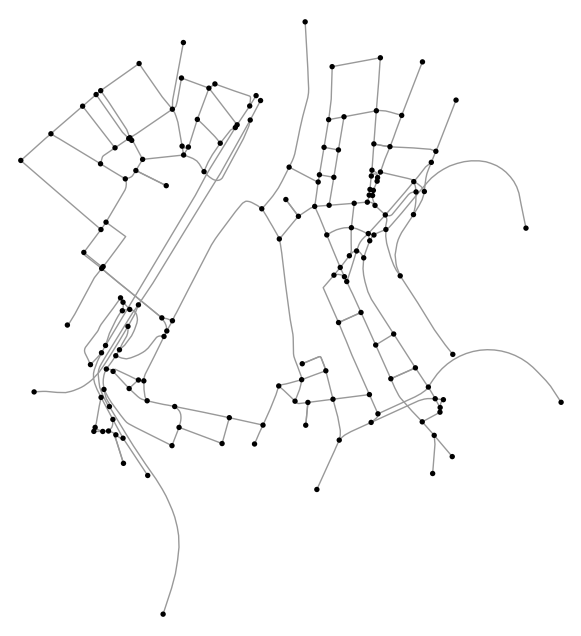

C:\Users\gio-x\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


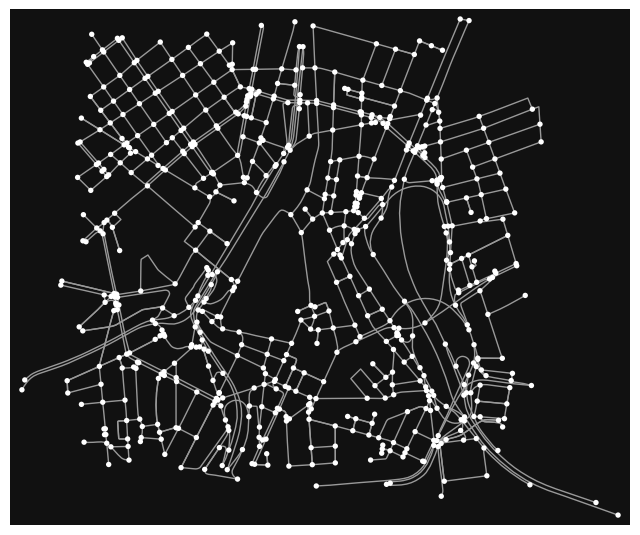

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
latlong, city = (-23.546, -46.634), "São Paulo"
dist = 500
G = ox.graph_from_point(latlong, dist = dist, truncate_by_edge = True, network_type="drive")
lnodes = list(G.nodes())
ox.plot_graph(G, bgcolor = "w", node_color = 'k')
G = ox.graph_from_point(latlong, dist = dist+500, truncate_by_edge = True, network_type="drive")
ox.plot_graph(G)

C:\Users\gio-x\AppData\Local\Temp\ipykernel_16232\3546754781.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]


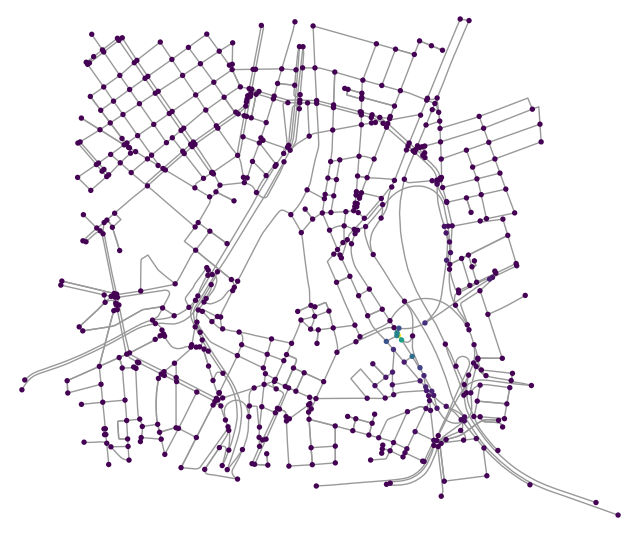

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
ut, EC, t = simulation(G, [lnodes[0]], qtd = [1])
ox.plot_graph(G, node_color=ut[-1], bgcolor = "w")

In [20]:
flow, X = comm_geo(G)
df = pd.DataFrame.from_dict(flow, orient = "index")
df

,0
"(597282, 130009702)",0.000000
"(597282, 25872025)",0.000000
"(597283, 445043546)",0.000000
"(597283, 25871833)",0.000000
"(25871670, 25871831)",0.000000
...,...
"(10573115224, 151243285)",19.710156
"(10724416487, 2389062254)",4.525389
"(11073528287, 3609406630)",13.369917
"(11073528287, 4307635045)",7.393095


In [24]:
all_u = []
all_t = []
for i in lnodes:
    ut, EC, t = simulation(G, [i], qtd = [1])
    all_u.append(ut[-1])
    all_t.append(t)

C:\Users\gio-x\AppData\Local\Temp\ipykernel_16232\3546754781.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]


ValueError: shapes (645,645) and (646,) not aligned: 645 (dim 1) != 646 (dim 0)

In [26]:
all_t

[8.269999999999868,
 6.739999999999901,
 5.239999999999933,
 6.1399999999999135,
 5.399999999999929]

In [ ]:
all_t

[4.809999999999942,
 5.879999999999919,
 6.689999999999902,
 12.689999999999774,
 9.659999999999838,
 12.589999999999776,
 4.809999999999942,
 6.689999999999902,
 12.119999999999786,
 22.800000000000765,
 22.050000000000647,
 17.14999999999988,
 20.370000000000385,
 17.39999999999992,
 20.66000000000043,
 22.080000000000652,
 18.24000000000005,
 12.319999999999782,
 11.4699999999998,
 11.409999999999801,
 31.570000000002135,
 28.640000000001677,
 25.700000000001218,
 28.640000000001677,
 4.809999999999942,
 14.489999999999736,
 19.96000000000032,
 14.30999999999974,
 19.77000000000029,
 23.180000000000824,
 19.58000000000026,
 7.329999999999888,
 12.009999999999788,
 12.38999999999978,
 10.929999999999811,
 15.919999999999705,
 17.98000000000001,
 28.640000000001677,
 5.879999999999919,
 17.91,
 19.12000000000019,
 11.93999999999979,
 4.809999999999942,
 17.189999999999888,
 16.409999999999766,
 20.200000000000358,
 18.700000000000124,
 4.809999999999942,
 12.679999999999774,
 5.879999

In [ ]:
import matplotlib as mpl
import matplotlib.cm as cm

In [ ]:
nx.set_node_attributes(G, dict(zip(G.nodes(),all_t)), "time")
nx.set_edge_attributes(G, nx.edge_betweenness_centrality(G), "bet")
cont = 0
for edge in G.edges:
    G[edge[0]][edge[1]][edge[2]]['COR'] = df["Cost"].iloc[cont]
    cont+=1

C:\Users\gio-x\AppData\Local\Temp\ipykernel_22524\2907431690.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hot')


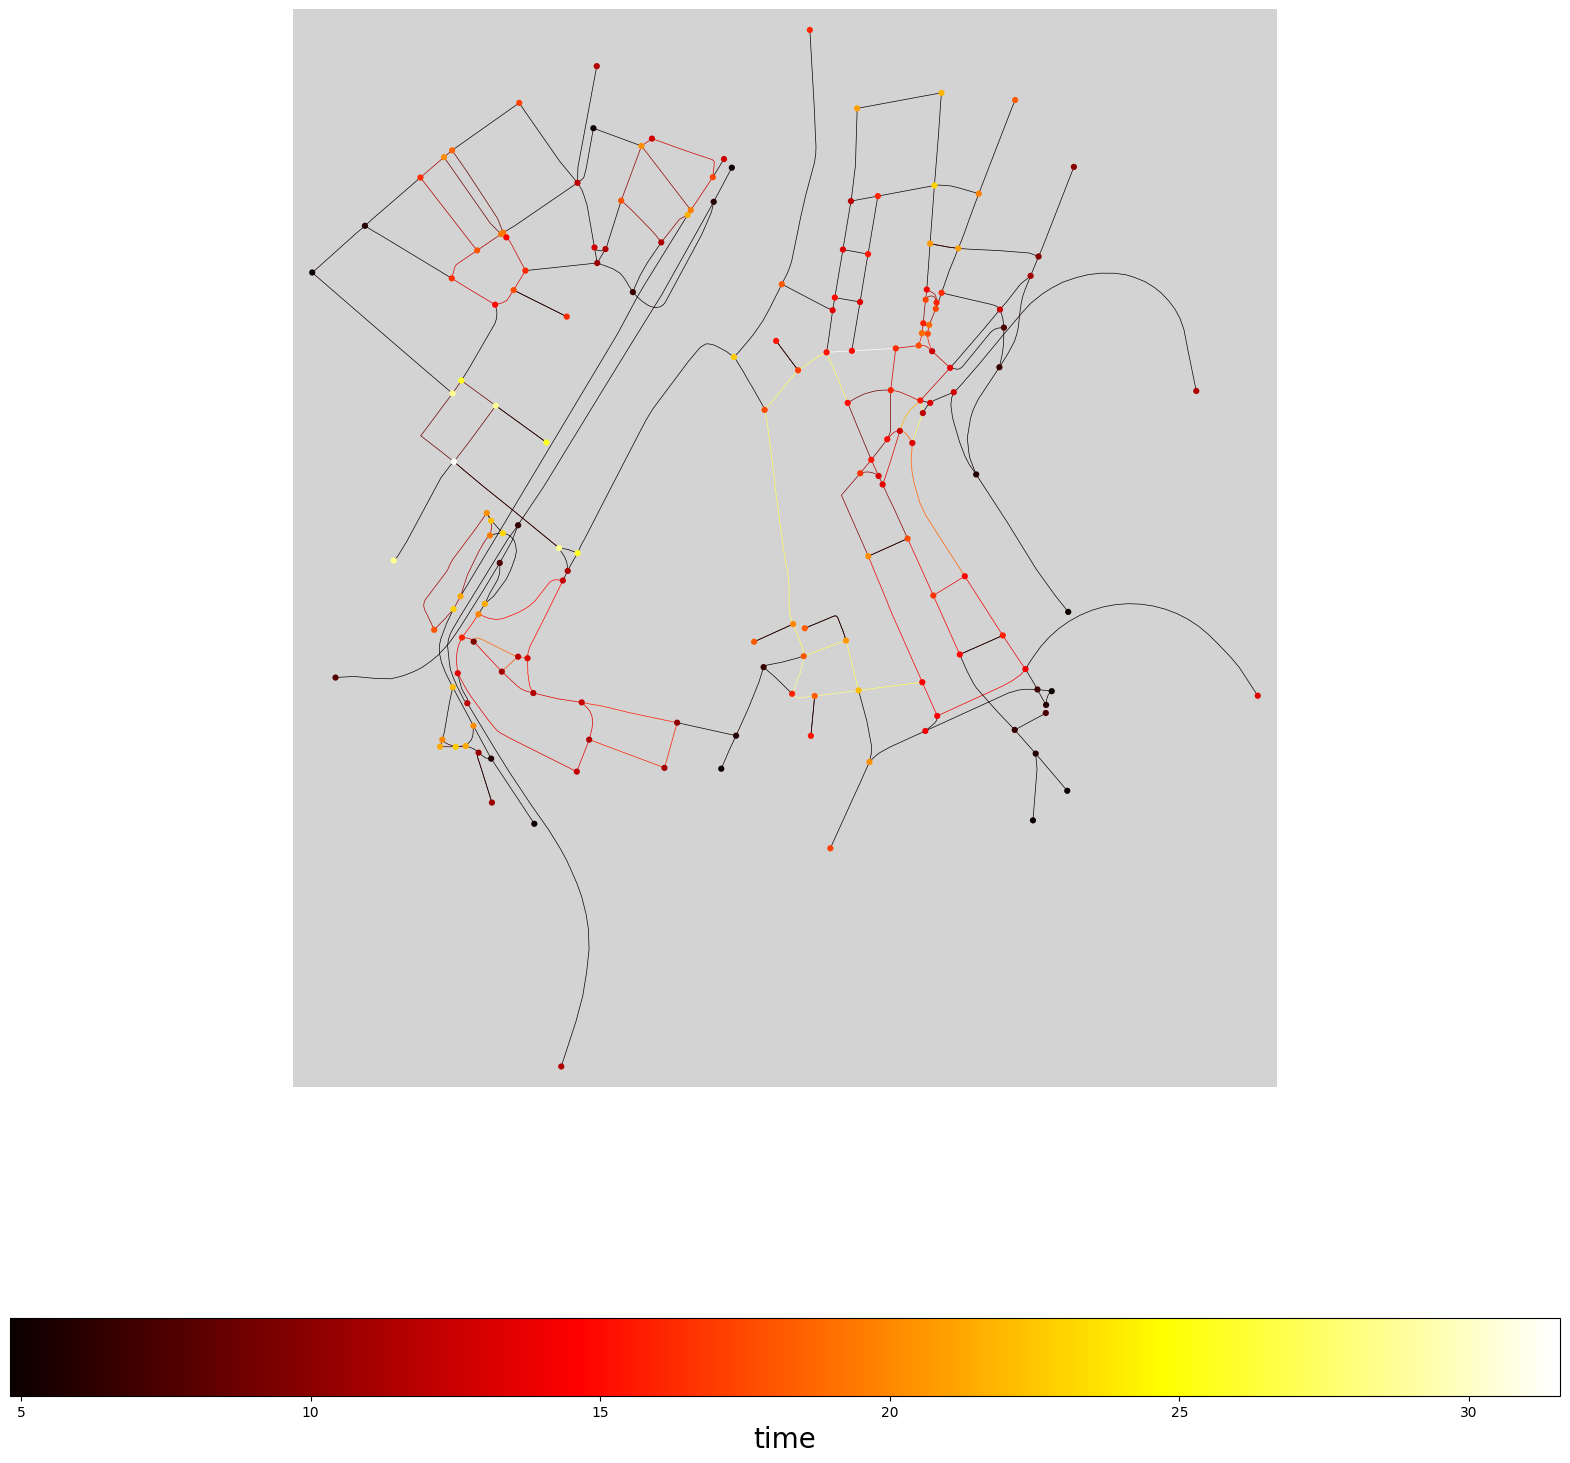

In [ ]:
cmap = plt.cm.get_cmap('hot')
norm=plt.Normalize(vmin=np.min(all_t), vmax=np.max(all_t))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
nc = ox.plot.get_node_colors_by_attr(G, attr="time", cmap="hot")
ec = ox.plot.get_edge_colors_by_attr(G, attr="COR", cmap="hot")

fig, ax = ox.plot_graph(G, node_color=nc, edge_color = ec, node_size=20, edge_linewidth=0.5, bgcolor = 'lightgray', show=False, figsize = (20,20))
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')
cb.set_label('time', fontsize = 20)
# fig.savefig('demo.png')

In [ ]:
nodes, edges = ox.graph_to_gdfs(G)

In [ ]:
nodes["C(tf)"] = ut[-1]
edges["COR"] = df["Cost"]

In [ ]:
m = edges.explore(column = "COR", cmap = "jet")
nodes.explore(m=m,column = "time", cmap = "jet")


ValueError: Invalid RGBA argument: 0.0

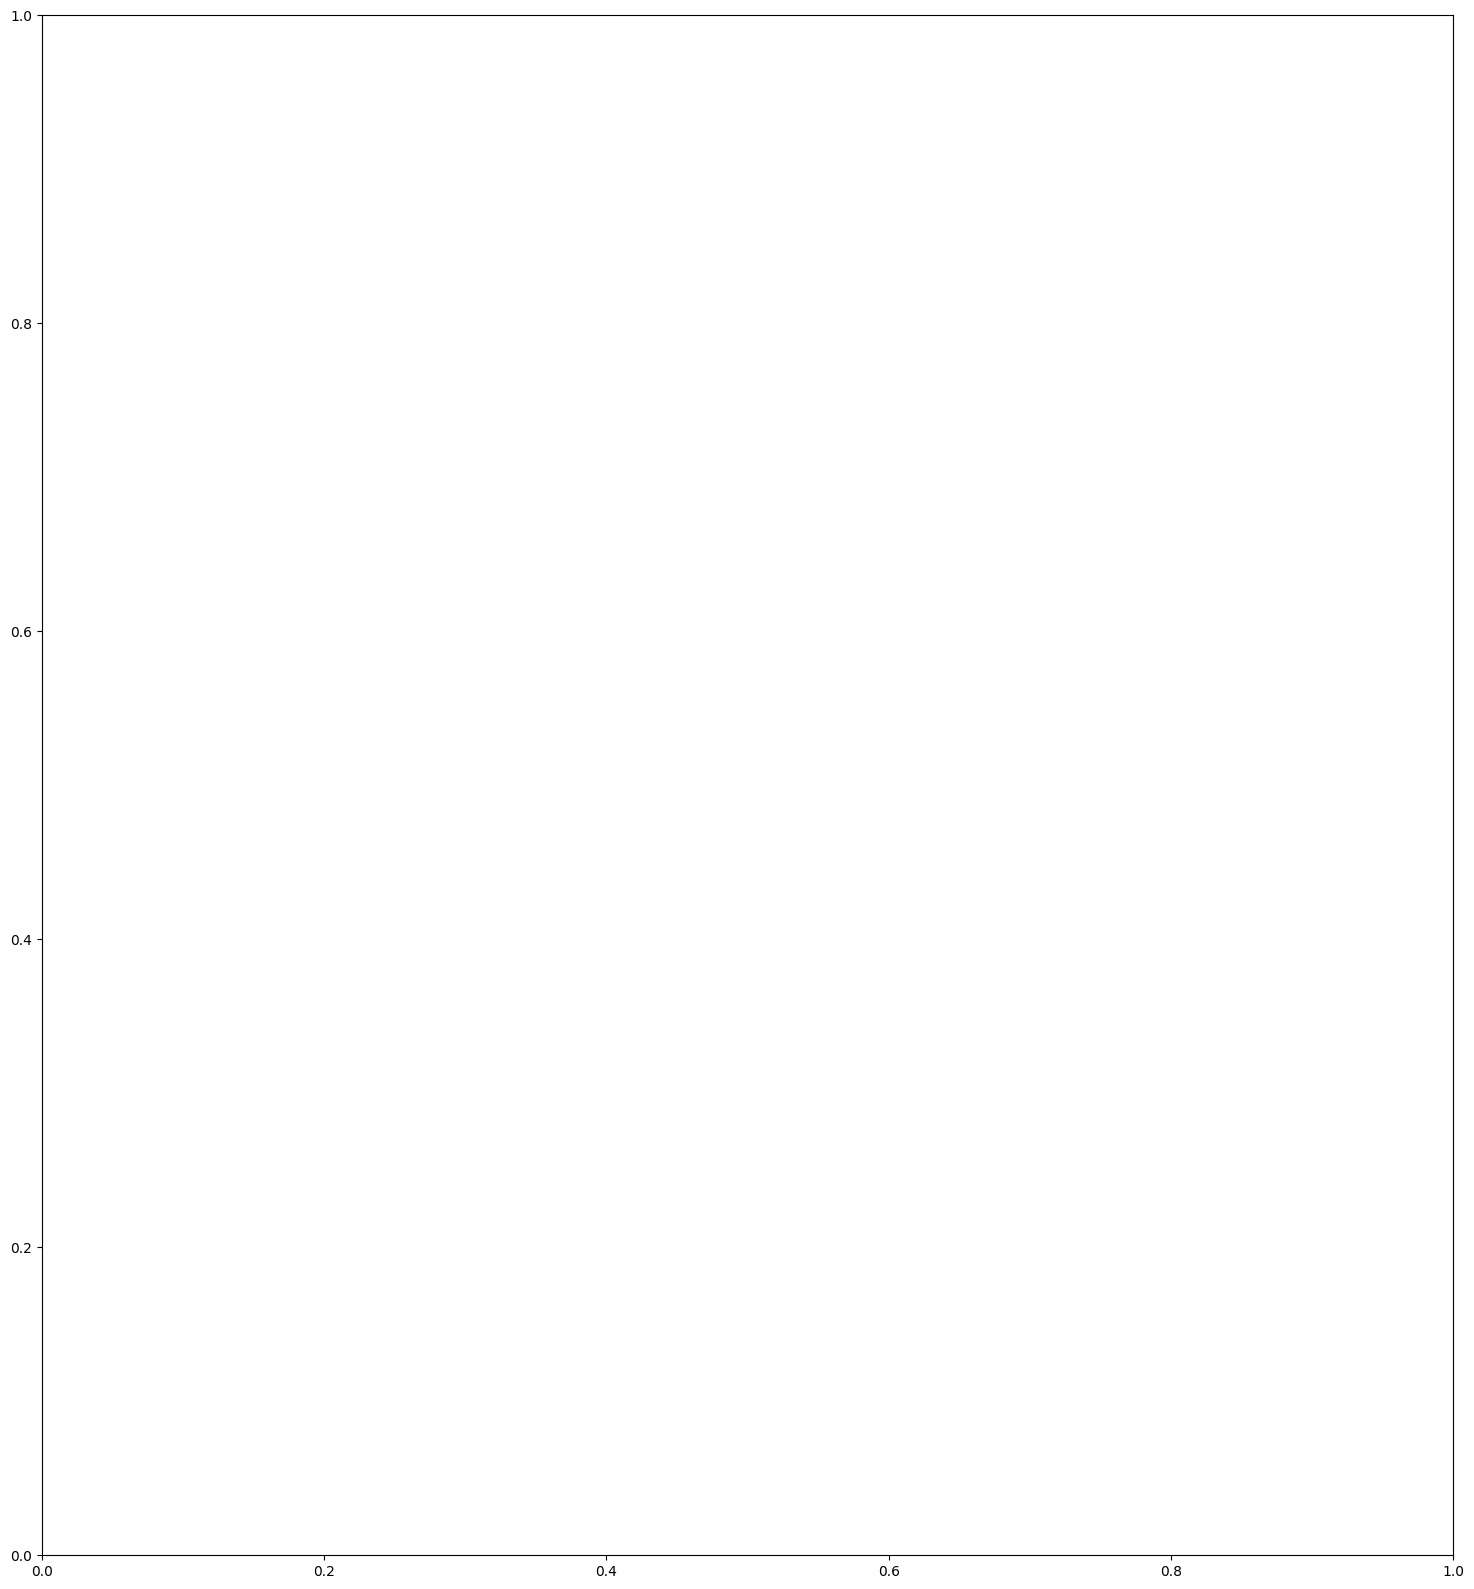

In [ ]:
cmap=plt.cm.jet
# plt.figure(figsize=(12,12))

vmin = np.min(ut[-1])
vmax = np.max(ut[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
fig, ax = ox.plot_graph(
    G, bgcolor="w", node_color=ut[-1], 
    node_size=50, 
    edge_color=df["Cost"],
    figsize = (20,20), show = False, close = False
)

plt.colorbar(sm, ax = ax)

# plt.gca().set_facecolor("lightgray")

plt.show()

## Random

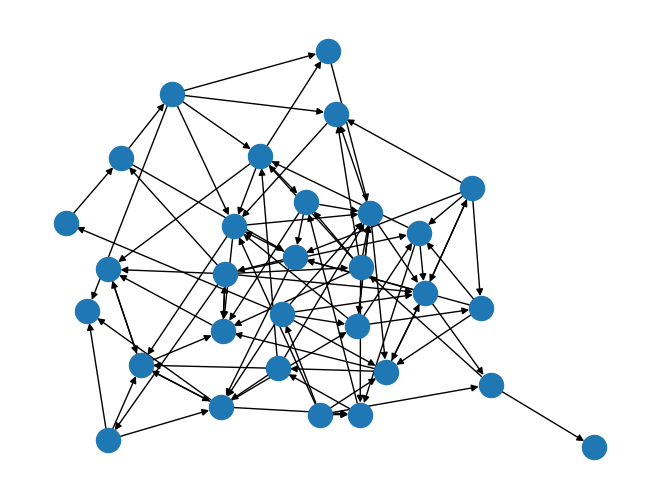

In [33]:
G =  nx.erdos_renyi_graph(n = 30, p = 0.1, directed = True, seed = 10)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)

In [39]:
all_u = []
all_t = []
df = calculations(G)
for i in range(0, len(G)):
    ut, EC, t = simulation(G, [i], qtd = [1])
    all_u.append(ut[-1])
    all_t.append(t)

dftime = pd.DataFrame(data = all_t, columns = ["time"], index = G.nodes())

C:\Users\gio-x\AppData\Local\Temp\ipykernel_16232\3546754781.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pos1 = np.where(lambda_1 == np.max(lambda_1))[0][0]


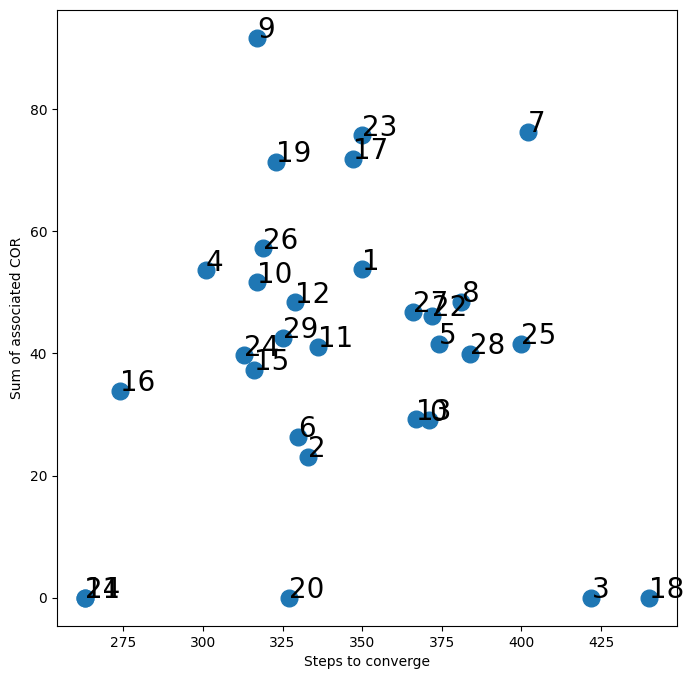

In [41]:
plt.figure(figsize = (8,8))
# plt.subplot(1, 3, 1)
# plt.title("Degree strength")
dftime["COR str"] = dict(G.degree(weight = 'COR'))
dftime["degree"] = dict(G.degree())
for i, txt in enumerate(dftime.index):
    plt.annotate(txt, (dftime['time'].loc[txt]/0.01, dftime["COR str"].loc[txt]), size = 20)
plt.plot(dftime["time"]/0.01,dftime["COR str"], 'o', markersize = 12)
plt.ylabel("Sum of associated COR")
plt.xlabel("Steps to converge")
plt.savefig(f"dynamics_conv_cor.pdf", bbox_inches='tight')
plt.show()

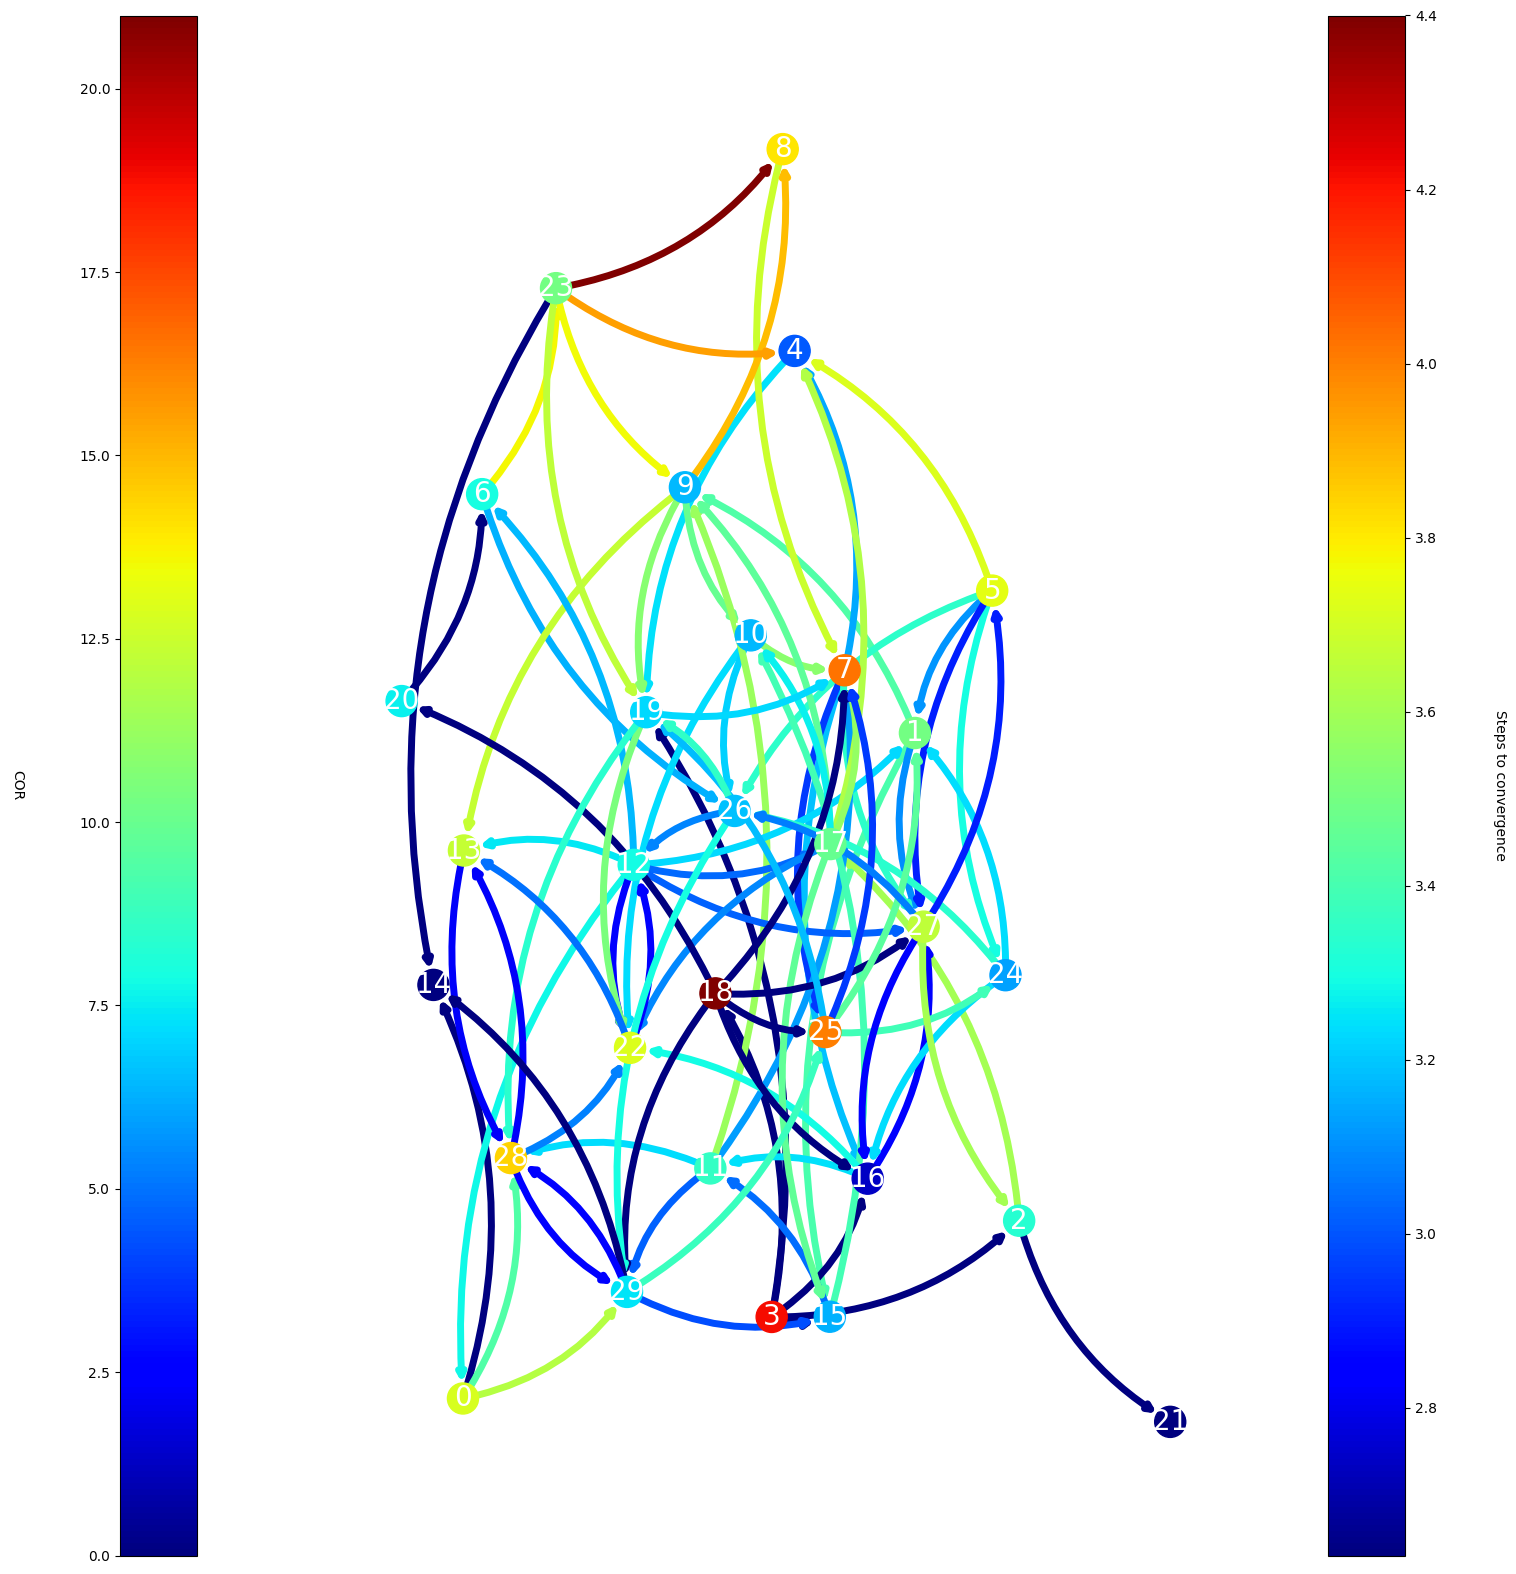

In [44]:
cmap=plt.cm.jet
cmap2=plt.cm.jet

options = {
    "node_color": all_t,
    "edge_color": df["Cost"],
    # "width": dict(zip(G.edges(),df["Cost"])),
    "edge_cmap": cmap2,
    "cmap": cmap,
    "with_labels": True,
    'font_size': 20,
    'font_color': 'w',
    'width' : 5 ,
    'node_size': 500
}


plt.figure(figsize=(20,20))

colors=all_t
cmap=plt.cm.jet
vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('Steps to convergence', rotation=270, labelpad = 50)

colors2=df["Cost"]
vmin2 = min(colors2)
vmax2 = max(colors2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin = vmin2, vmax=vmax2))
sm._A = []
cbar = plt.colorbar(sm, ax = plt.gca(), orientation = 'vertical', location = "left")
cbar.set_label('COR', rotation=270, labelpad = 50)

nx.draw(G, pos, vmin=vmin, vmax=vmax, connectionstyle='arc3, rad = 0.2',**options)
# nx.draw(G, pos, connectionstyle='arc3, rad = 0.2', width = list(df["Cost"]*2) ,**options)
plt.show()